#### Mulit fidelity outputs
This notebook generates multi-fidelity output of the homeless care services. We have a fluid flow model, an $M_t/M/h_t$ queueing model and a high fidelity simulation model. 

In [2]:
import json
import scipy
import matplotlib.pyplot as plt
import sys
import os

In [3]:
# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

# Now you can import your module
import simulation_model as sm

In [4]:
# Data
with open('../data/data.json') as json_file:
    data = json.load(json_file)

solution = data['solution']

# DES
s = sm.SimulationModel(data, solution)
s.analyse()

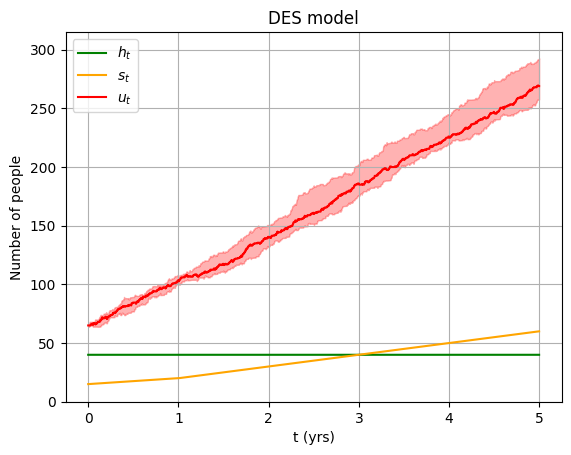

In [11]:
# PLOTTING

# general plotting setup
fig, ax = plt.subplots()
ymax = max(s.results['unsheltered_q_over_time'].max(), max(s.s), max(s.h))
        
# plot solution
x = [i/365 for i in range((s.end_of_simulation)*365)]

ax.plot(x, s.h, color = 'green')
ax.plot(x, s.s, color = 'orange')
ax.plot(x, s.median, color = 'red')
ax.fill_between(x, s.low, s.high, color='red', alpha=0.3)
ax.set(title = "DES model")
ax.legend(["$h_t$", "$s_t$", "$u_t$"], loc="upper left")
ax.set(xlabel='t (yrs)', ylabel='Number of people')
ax.grid()
ax.set_ylim(0, ymax*1.05)
ax.label_outer()
        
# display
plt.show()

Linear regression (arrival rate):  y = 27.5785 + 2.4736 x
MSE = 0.1044


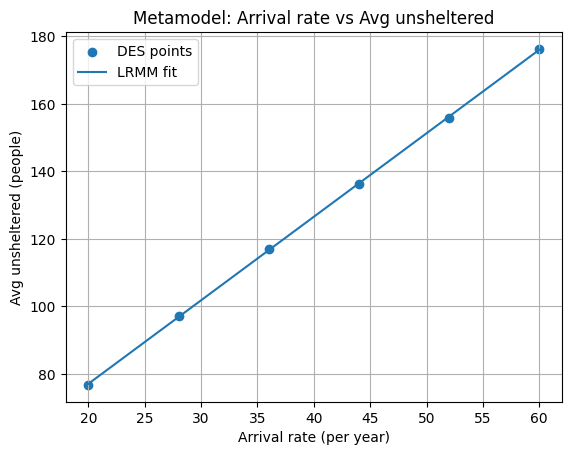

In [16]:
# Linear regression metamodel (arrival rate ∈ [20, 60])
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

# 1) experiment designn
x_vals = np.linspace(20, 60, 6)  
y_vals = []

# 2) run DES for each x and record the scalar response y (avg unsheltered over reps)
for x in x_vals:
    d = deepcopy(data)
    d['arrival_rates'] = [float(x)] * len(d['arrival_rates'])
    sim = sm.SimulationModel(d, d['solution'])
    sim.analyse()
    y = float(np.mean(sim.results['unsheltered_q_avg']))  
    y_vals.append(y)

x = np.asarray(x_vals, dtype=float)
y = np.asarray(y_vals, dtype=float)

# 3) fit y = b0 + b1 
x_mean, y_mean = x.mean(), y.mean()
b1 = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean) ** 2)
b0 = y_mean - b1 * x_mean
y_hat = b0 + b1 * x
mse = float(np.mean((y - y_hat) ** 2))

# 4) plot des 
fig, ax = plt.subplots()
ax.scatter(x, y, label='DES points')
xx = np.linspace(x.min(), x.max(), 200)
ax.plot(xx, b0 + b1 * xx, label='LRMM fit')

ax.set_title('Metamodel: Arrival rate vs Avg unsheltered')
ax.set_xlabel('Arrival rate (per year)')
ax.set_ylabel('Avg unsheltered (people)')
ax.grid(True)
ax.legend(loc='best')

# 5) regression form and mse
print(f"Linear regression (arrival rate):  y = {b0:.4f} + {b1:.4f} x")
print(f"MSE = {mse:.4f}")
plt.show()


Linear regression (re-entry rate):  y = 109.3241 + 26.9192 x
MSE = 0.3500


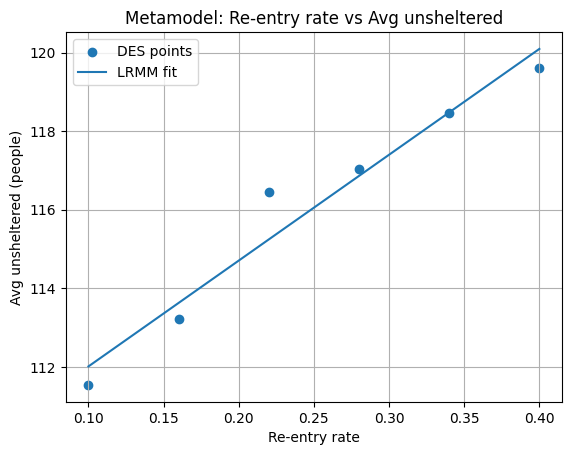

In [23]:
# Linear regression metamodel (re-entry rate ∈ [0.1, 0.4])
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

# 1) Experiment design
x_vals = np.linspace(0.1, 0.4, 6)
y_vals = []

# 2) Run DES for each x and record the scalar response y (avg unsheltered over reps)
for x in x_vals:
    d = deepcopy(data)
    d['reentry_rate'] = float(x)  # vary only the re-entry rate
    sim = sm.SimulationModel(d, d['solution'])
    sim.analyse()
    y = float(np.mean(sim.results['unsheltered_q_avg']))
    y_vals.append(y)

x = np.asarray(x_vals, dtype=float)
y = np.asarray(y_vals, dtype=float)

# 3) Fit y = b0 + b1 x via OLS
x_mean, y_mean = x.mean(), y.mean()
b1 = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean) ** 2)
b0 = y_mean - b1 * x_mean
y_hat = b0 + b1 * x
mse = float(np.mean((y - y_hat) ** 2))

# 4) Plot DES points and fitted line
fig, ax = plt.subplots()
ax.scatter(x, y, label='DES points')
xx = np.linspace(x.min(), x.max(), 200)
ax.plot(xx, b0 + b1 * xx, label='LRMM fit')

ax.set_title('Metamodel: Re-entry rate vs Avg unsheltered')
ax.set_xlabel('Re-entry rate')
ax.set_ylabel('Avg unsheltered (people)')
ax.grid(True)
ax.legend(loc='best')

# 5) Regression form and MSE
print(f"Linear regression (re-entry rate):  y = {b0:.4f} + {b1:.4f} x")
print(f"MSE = {mse:.4f}")
plt.show()


Linear regression (time between building, in days):  y = 114.4296 + 2.0468 x
MSE = 3.0234


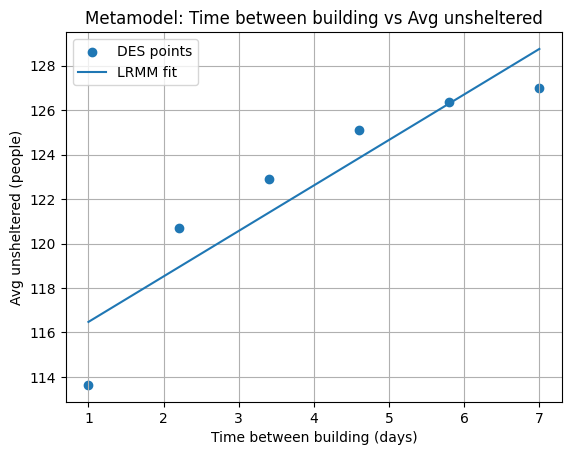

In [ ]:
# Linear regression metamodel (time between building ∈ [1, 7] days)
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

# 1) Experiment design 
x_days = np.linspace(1, 7, 6)          
x_vals = x_days / 365.0                 # convert to YEARS for the DES parameter
y_vals = []

# 2) Run DES for each x and record the scalar response y (avg unsheltered over reps)
for x in x_vals:
    d = deepcopy(data)
    d['time_btwn_building'] = float(x)  # vary only the build cadence
    sim = sm.SimulationModel(d, d['solution'])
    sim.analyse()
    y = float(np.mean(sim.results['unsheltered_q_avg']))
    y_vals.append(y)

x = np.asarray(x_vals, dtype=float)
x_plot = x_days                          
y = np.asarray(y_vals, dtype=float)

# 3) Fit y = b0 + b1 x via OLS  (fit vs. DAYS so slope is per-day)
xm, ym = x_plot.mean(), y.mean()
b1 = np.sum((x_plot - xm) * (y - ym)) / np.sum((x_plot - xm) ** 2)
b0 = ym - b1 * xm
y_hat = b0 + b1 * x_plot
mse = float(np.mean((y - y_hat) ** 2))

# 4) Plot DES points and fitted line
fig, ax = plt.subplots()
ax.scatter(x_plot, y, label='DES points')
xx = np.linspace(x_plot.min(), x_plot.max(), 200)
ax.plot(xx, b0 + b1 * xx, label='LRMM fit')

ax.set_title('Metamodel: Time between building vs Avg unsheltered')
ax.set_xlabel('Time between building (days)')
ax.set_ylabel('Avg unsheltered (people)')
ax.grid(True)
ax.legend(loc='best')

# 5) Regression form and MSE
print(f"Linear regression (time between building, in days):  y = {b0:.4f} + {b1:.4f} x")
print(f"MSE = {mse:.4f}")
plt.show()


Linear regression (initial demand):  y = -3.0129 + 0.9740 x
MSE = 0.6036


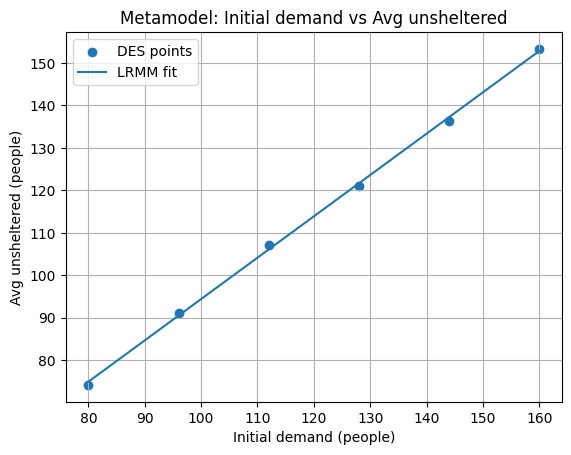

In [25]:
# Linear regression metamodel (initial demand ∈ [80, 160])
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

# 1) Experiment design
x_vals = np.linspace(80, 160, 6)  # initial demand values
y_vals = []

# 2) Run DES for each x and record scalar response y (avg unsheltered over reps)
for x in x_vals:
    d = deepcopy(data)
    d['initial_demand'] = int(x)  # vary only initial demand
    sim = sm.SimulationModel(d, d['solution'])
    sim.analyse()
    y = float(np.mean(sim.results['unsheltered_q_avg']))
    y_vals.append(y)

x = np.asarray(x_vals, dtype=float)
y = np.asarray(y_vals, dtype=float)

# 3) Fit y = b0 + b1 x via OLS
xm, ym = x.mean(), y.mean()
b1 = np.sum((x - xm) * (y - ym)) / np.sum((x - xm) ** 2)
b0 = ym - b1 * xm
y_hat = b0 + b1 * x
mse = float(np.mean((y - y_hat) ** 2))

# 4) Plot DES points and fitted line
fig, ax = plt.subplots()
ax.scatter(x, y, label='DES points')
xx = np.linspace(x.min(), x.max(), 200)
ax.plot(xx, b0 + b1 * xx, label='LRMM fit')

ax.set_title('Metamodel: Initial demand vs Avg unsheltered')
ax.set_xlabel('Initial demand (people)')
ax.set_ylabel('Avg unsheltered (people)')
ax.grid(True)
ax.legend(loc='best')

# 5) Regression form and MSE
print(f"Linear regression (initial demand):  y = {b0:.4f} + {b1:.4f} x")
print(f"MSE = {mse:.4f}")
plt.show()


Linear regression (housing triangular mid):  y = 110.1534 + 0.6449 x
MSE = 0.1074


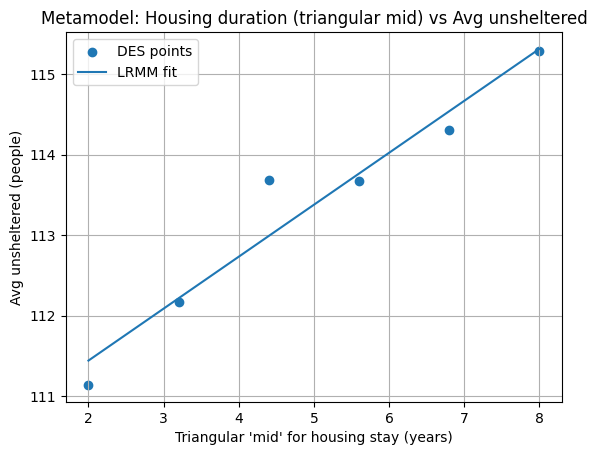

In [ ]:
# Linear regression metamodel (housing triangular 'mid' ∈ [2.0, 8])
# Keeps low=0, high=8 fixed; ensure mid ≤ high.
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

# 1) Experiment design
x_vals = np.linspace(2.0, 8, 6)  # triangular 'mid' (years)
y_vals = []

# 2) Run DES per x
for x in x_vals:
    d = deepcopy(data)
    d['service_dist_triangle']['mid'] = float(min(x, d['service_dist_triangle']['high']))  # enforce mid ≤ high
    sim = sm.SimulationModel(d, d['solution'])
    sim.analyse()
    y_vals.append(float(np.mean(sim.results['unsheltered_q_avg'])))

x = np.asarray(x_vals, float)
y = np.asarray(y_vals, float)

# 3)  fit y = b0 + b1x
xm, ym = x.mean(), y.mean()
b1 = np.sum((x - xm)*(y - ym)) / np.sum((x - xm)**2)
b0 = ym - b1*xm
y_hat = b0 + b1*x
mse = float(np.mean((y - y_hat)**2))

# 4) plot
fig, ax = plt.subplots()
ax.scatter(x, y, label='DES points')
xx = np.linspace(x.min(), x.max(), 200)
ax.plot(xx, b0 + b1*xx, label='LRMM fit')

ax.set_title("Metamodel: Housing duration (triangular mid) vs Avg unsheltered")
ax.set_xlabel("Triangular 'mid' for housing stay (years)")
ax.set_ylabel('Avg unsheltered (people)')
ax.grid(True); ax.legend(loc='best')

# 5) prints
print(f"Linear regression (housing triangular mid):  y = {b0:.4f} + {b1:.4f} x")
print(f"MSE = {mse:.4f}")
plt.show()


Linear regression (initial capacity — housing):  y = 157.1656 + -1.2167 x
MSE = 14.7056


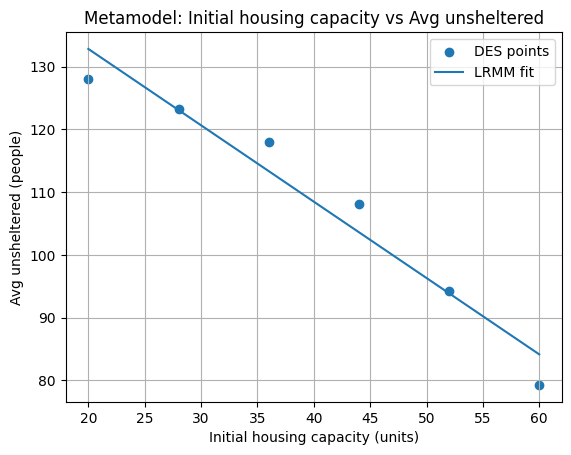

In [ ]:
# Linear regression metamodel (initial capacity — housing ∈ [20, 60])
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

# 1) Experiment design
x_vals = np.linspace(20, 60, 6)  # initial housing units
y_vals = []

# 2) Run DES per x
for x in x_vals:
    d = deepcopy(data)
    d['initial_capacity']['housing'] = int(x)
    sim = sm.SimulationModel(d, d['solution'])
    sim.analyse()
    y_vals.append(float(np.mean(sim.results['unsheltered_q_avg'])))

x = np.asarray(x_vals, float)
y = np.asarray(y_vals, float)

# 3) fit y = b0 + b1 x
xm, ym = x.mean(), y.mean()
b1 = np.sum((x - xm)*(y - ym)) / np.sum((x - xm)**2)
b0 = ym - b1*xm
y_hat = b0 + b1*x
mse = float(np.mean((y - y_hat)**2))

# 4) plots
fig, ax = plt.subplots()
ax.scatter(x, y, label='DES points')
xx = np.linspace(x.min(), x.max(), 200)
ax.plot(xx, b0 + b1*xx, label='LRMM fit')

ax.set_title('Metamodel: Initial housing capacity vs Avg unsheltered')
ax.set_xlabel('Initial housing capacity (units)')
ax.set_ylabel('Avg unsheltered (people)')
ax.grid(True); ax.legend(loc='best')

# 5) prints
print(f"Linear regression (initial capacity — housing):  y = {b0:.4f} + {b1:.4f} x")
print(f"MSE = {mse:.4f}")
plt.show()


Linear regression (initial capacity — shelter):  y = 157.3369 + -0.2872 x
MSE = 4.3671


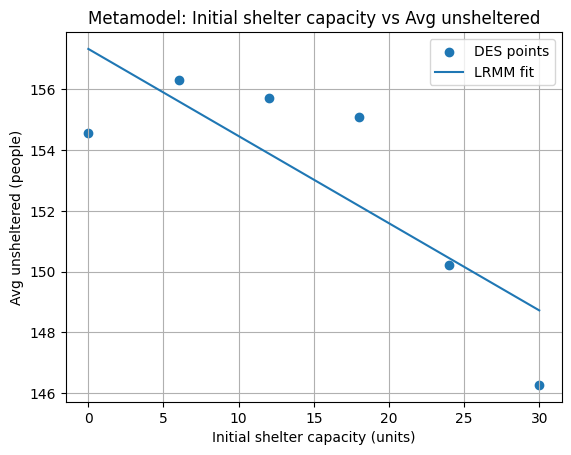

In [7]:
# Linear regression metamodel (initial capacity — shelter ∈ [0, 30])
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

# 1) Experiment design
x_vals = np.linspace(0, 30, 6)  # initial shelter units
y_vals = []

# 2) Run DES per x
for x in x_vals:
    d = deepcopy(data)
    d['initial_capacity']['shelter'] = int(x)
    sim = sm.SimulationModel(d, d['solution'])
    sim.analyse()
    y_vals.append(float(np.mean(sim.results['unsheltered_q_avg'])))

x = np.asarray(x_vals, float)
y = np.asarray(y_vals, float)

# 3) fit y = b0 + b1 x
xm, ym = x.mean(), y.mean()
b1 = np.sum((x - xm)*(y - ym)) / np.sum((x - xm)**2)
b0 = ym - b1*xm
y_hat = b0 + b1*x
mse = float(np.mean((y - y_hat)**2))

# 4) plots
fig, ax = plt.subplots()
ax.scatter(x, y, label='DES points')
xx = np.linspace(x.min(), x.max(), 200)
ax.plot(xx, b0 + b1*xx, label='LRMM fit')

ax.set_title('Metamodel: Initial shelter capacity vs Avg unsheltered')
ax.set_xlabel('Initial shelter capacity (units)')
ax.set_ylabel('Avg unsheltered (people)')
ax.grid(True); ax.legend(loc='best')

# 5) prints
print(f"Linear regression (initial capacity — shelter):  y = {b0:.4f} + {b1:.4f} x")
print(f"MSE = {mse:.4f}")
plt.show()


Linear regression (annual housing additions):  y = 188.9399 + -2.6970 x
MSE = 0.4935


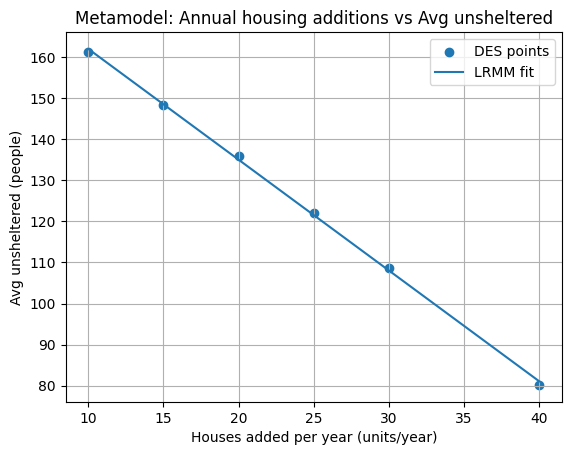

In [ ]:
# Linear regression metamodel (annual housing additions ∈ [10, 40] houses/year)
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

# 1) Experiment design: add K houses EACH YEAR (absolute addition per year)
x_vals = np.array([10, 15, 20, 25, 30, 40], dtype=int)  # houses per year
y_vals = []

n_years = len(data['solution']['housing'])

# 2) Run DES for each K and record scalar response y (avg unsheltered over reps)
for K in x_vals:
    d = deepcopy(data)

    # Construct an annual capacity plan where capacity increases by K each year
    init_h = d['initial_capacity']['housing']
    d['solution']['housing'] = [init_h + K * (i + 1) for i in range(n_years)]

    # (Keep shelter plan as baseline)
    sim = sm.SimulationModel(d, d['solution'])
    sim.analyse()
    y_vals.append(float(np.mean(sim.results['unsheltered_q_avg'])))

x = np.asarray(x_vals, dtype=float)   # K = houses added per year
y = np.asarray(y_vals, dtype=float)

# 3) Fit y = b0 + b1 
xm, ym = x.mean(), y.mean()
b1 = np.sum((x - xm) * (y - ym)) / np.sum((x - xm) ** 2)
b0 = ym - b1 * xm
y_hat = b0 + b1 * x
mse = float(np.mean((y - y_hat) ** 2))

# 4) Plot DES points and fitted line
fig, ax = plt.subplots()
ax.scatter(x, y, label='DES points')
xx = np.linspace(x.min(), x.max(), 200)
ax.plot(xx, b0 + b1 * xx, label='LRMM fit')

ax.set_title('Metamodel: Annual housing additions vs Avg unsheltered')
ax.set_xlabel('Houses added per year (units/year)')
ax.set_ylabel('Avg unsheltered (people)')
ax.grid(True)
ax.legend(loc='best')

# 5) Regression form and MSE
print(f"Linear regression (annual housing additions):  y = {b0:.4f} + {b1:.4f} x")
print(f"MSE = {mse:.4f}")
plt.show()


Linear regression (Year-1-only extra shelter):  y = 187.7980 + -0.9003 x
MSE = 0.1597


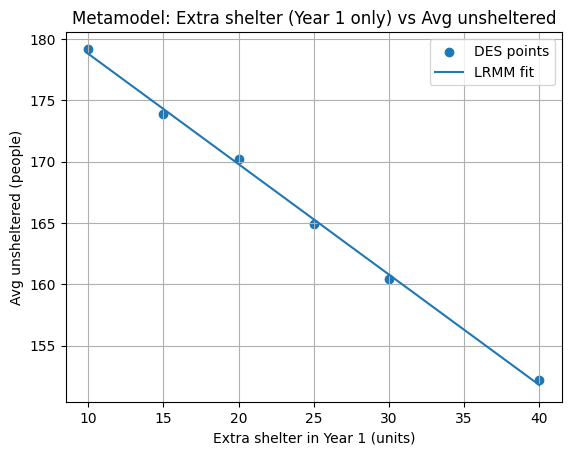

In [ ]:
# Linear regression metamodel — add extra SHELTER only in Year 1 (temporary), ∈ [10, 40] units
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

# 1) Experiment design: add K shelter units ONLY during Year 1, then revert to baseline
x_vals = np.array([10, 15, 20, 25, 30, 40], dtype=int)  # extra shelter units in Year 1
y_vals = []

base_plan = data['solution']['shelter'][:]            # e.g., [15,15,15,15,15]
init_shelter = data['initial_capacity']['shelter']
n_years = len(base_plan)

for K in x_vals:
    d = deepcopy(data)
    # temporary extra shelter capacity in Year 1 only, revert from Year 2
    tmp_plan = base_plan[:]                            # copy baseline
    tmp_plan[0] = init_shelter + K                     # Year 1 capacity = init + K
    # (Years 2..n keep baseline values)
    d['solution']['shelter'] = tmp_plan

    sim = sm.SimulationModel(d, d['solution'])
    sim.analyse()
    y_vals.append(float(np.mean(sim.results['unsheltered_q_avg'])))

x = np.asarray(x_vals, float)
y = np.asarray(y_vals, float)

# 3) Fit y = b0 + b1 x
xm, ym = x.mean(), y.mean()
b1 = np.sum((x - xm) * (y - ym)) / np.sum((x - xm) ** 2)
b0 = ym - b1 * xm
y_hat = b0 + b1 * x
mse = float(np.mean((y - y_hat) ** 2))

# 4) Plot DES points and fitted line
fig, ax = plt.subplots()
ax.scatter(x, y, label='DES points')
xx = np.linspace(x.min(), x.max(), 200)
ax.plot(xx, b0 + b1 * xx, label='LRMM fit')

ax.set_title('Metamodel: Extra shelter (Year 1 only) vs Avg unsheltered')
ax.set_xlabel('Extra shelter in Year 1 (units)')
ax.set_ylabel('Avg unsheltered (people)')
ax.grid(True)
ax.legend(loc='best')

# 5) Regression form and MSE
print(f"Linear regression (Year-1-only extra shelter):  y = {b0:.4f} + {b1:.4f} x")
print(f"MSE = {mse:.4f}")
plt.show()


2D linear-quadratic metamodel (persistent extras from Year 1):
y = 155.8194 + -1.1716·H + -0.9334·S + 0.002514·H^2 + 0.001115·S^2 + 0.000000·(H·S)
MSE = 1.4854   |   R^2 = 0.9959


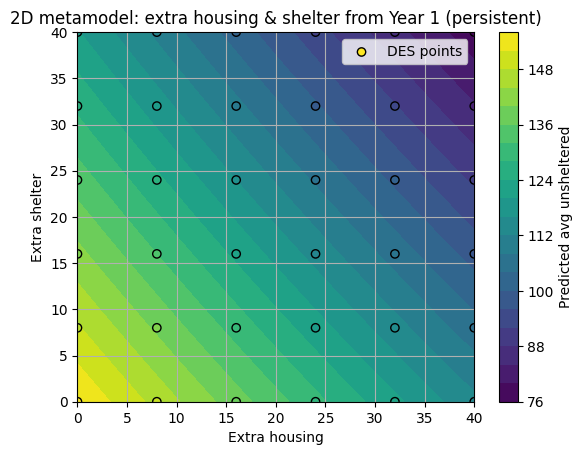

In [ ]:
# 2D metamodel — extra HOUSING & SHELTER from Year 1 onward , 6-term regression:
# y = b0 + b1*H + b2*S + b3*H^2 + b4*S^2 + b5*(H*S)

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

H_vals = np.linspace(0, 40, 6).astype(int)   # extra housing from Year 1 (persisting)
S_vals = np.linspace(0, 40, 6).astype(int)   # extra shelter from Year 1 (persisting)

# If you want the extras ONLY in Year 1 (not persistent), set:
PERSIST = True  # False -> only Year 1 gets the extra units

base_h = list(data['solution']['housing'])
base_s = list(data['solution']['shelter'])
n_years = len(base_h)

pairs = []
ys = []

for H in H_vals:
    for S in S_vals:
        d = deepcopy(data)
        if PERSIST:
            d['solution']['housing'] = [h + H for h in base_h]
            d['solution']['shelter'] = [s + S for s in base_s]
        else:
            d['solution']['housing'] = [base_h[0] + H] + base_h[1:]
            d['solution']['shelter'] = [base_s[0] + S] + base_s[1:]

        sim = sm.SimulationModel(d, d['solution'])
        sim.analyse()
        y = float(np.mean(sim.results['unsheltered_q_avg']))  

        pairs.append((H, S))
        ys.append(y)

pairs = np.asarray(pairs, float)
ys = np.asarray(ys, float)
H = pairs[:, 0]
S = pairs[:, 1]

# --- Build 6-term design matrix and fit that minimises MSE ---
X = np.column_stack([
    np.ones_like(H),        # b0
    H,                      # b1
    S,                      # b2
    H**2,                   # b3
    S**2,                   # b4
    H*S                     # b5
])
beta, *_ = np.linalg.lstsq(X, ys, rcond=None)
y_hat = X @ beta
mse = float(np.mean((ys - y_hat)**2))
ss_res = float(np.sum((ys - y_hat)**2))
ss_tot = float(np.sum((ys - ys.mean())**2))
r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

b0, b1, b2, b3, b4, b5 = beta

# ---  regression form ---
print("2D linear-quadratic metamodel:")
print(f"y = {b0:.4f} + {b1:.4f}·H + {b2:.4f}·S + {b3:.6f}·H^2 + {b4:.6f}·S^2 + {b5:.6f}·(H·S)")
print(f"MSE = {mse:.4f}   |   R^2 = {r2:.4f}")

# --- Plot: contour of fitted surface + DES points overlay ---
H_grid = np.linspace(H_vals.min(), H_vals.max(), 60)
S_grid = np.linspace(S_vals.min(), S_vals.max(), 60)
HH, SS = np.meshgrid(H_grid, S_grid, indexing='ij')
YY = (b0
      + b1*HH + b2*SS
      + b3*HH**2 + b4*SS**2
      + b5*(HH*SS))

fig, ax = plt.subplots()
cs = ax.contourf(HH, SS, YY, levels=20)
cbar = plt.colorbar(cs, ax=ax)
cbar.set_label('Predicted avg unsheltered')

ax.scatter(H, S, c=ys, edgecolor='k', label='DES points')
ax.set_title('2D metamodel: extra housing & shelter from Year 1')
ax.set_xlabel('Extra housing')
ax.set_ylabel('Extra shelter')
ax.grid(True)
ax.legend(loc='best')
plt.show()


Housing metamodel: y = 190.5734 + -2.7356 x   |   MSE = 97.3734


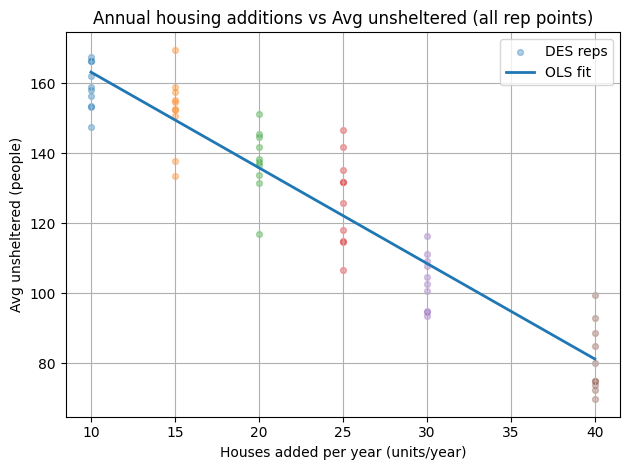

In [ ]:
#Annual HOUSING additions (10–40 per year), all rep points, not average
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

# Design: add K houses EACH YEAR from Year 1 onward 
x_vals = np.array([10, 15, 20, 25, 30, 40], dtype=int)

all_x, all_y = [], []
per_x_y = []  

n_years = len(data['solution']['housing'])
init_h = data['initial_capacity']['housing']

for K in x_vals:
    d = deepcopy(data)
    d['solution']['housing'] = [init_h + K * (i + 1) for i in range(n_years)]

    sim = sm.SimulationModel(d, d['solution'])
    sim.analyse()

    y_reps = np.asarray(sim.results['unsheltered_q_avg'], dtype=float)  
    per_x_y.append(y_reps)
    all_x.append(np.full_like(y_reps, K, dtype=float))
    all_y.append(y_reps)

X_all = np.concatenate(all_x)
Y_all = np.concatenate(all_y)

# y = b0 + b1 x
xm, ym = X_all.mean(), Y_all.mean()
b1 = np.sum((X_all - xm) * (Y_all - ym)) / np.sum((X_all - xm) ** 2)
b0 = ym - b1 * xm
mse = float(np.mean((Y_all - (b0 + b1 * X_all)) ** 2))

# Plot: vertical columns
fig, ax = plt.subplots()
first = True
for K, y_reps in zip(x_vals, per_x_y):
    ax.scatter(np.full_like(y_reps, K, dtype=float), y_reps,
               s=18, alpha=0.35, label='DES reps' if first else None)
    first = False

xx = np.linspace(x_vals.min(), x_vals.max(), 200)
ax.plot(xx, b0 + b1 * xx, linewidth=2, label='OLS fit')

ax.set_title('Annual housing additions vs Avg unsheltered (all rep points)')
ax.set_xlabel('Houses added per year (units/year)')
ax.set_ylabel('Avg unsheltered (people)')
ax.grid(True)
ax.legend(loc='best')

print(f"Housing metamodel: y = {b0:.4f} + {b1:.4f} x   |   MSE = {mse:.4f}")

plt.tight_layout()
plt.savefig("housing1.png", dpi=300, bbox_inches="tight", pad_inches=0.02, facecolor="white")
plt.show()



In [20]:
import numpy as np
import pandas as pd

try:
    df = df_ff4.copy()
except NameError:
    df = pd.read_csv("ff4_results.csv")

base_rate_per_year = float(np.mean(data['arrival_rates'])) 

df['A_rate'] = df['A'] * base_rate_per_year 

H0 = df['H'].mean()
S0 = df['S'].mean()
R0 = df['R'].mean()
A0 = df['A_rate'].mean()               

df['Hs']  = (df['H']      - H0) / 1.0
df['Ss']  = (df['S']      - S0) / 1.0
df['Rs']  = (df['R']      - R0) / 0.10
df['As10']= (df['A_rate'] - A0) / 1.0   

# Build full quadratic + pairwise interactions on the scaled variables
X_cols = {
    "b0"  : np.ones(len(df)),
    "bH"  : df['Hs'],
    "bS"  : df['Ss'],
    "bA"  : df['As10'],          
    "bR"  : df['Rs'],
    "bH2" : df['Hs']**2,
    "bS2" : df['Ss']**2,
    "bA2" : df['As10']**2,
    "bR2" : df['Rs']**2,
    "bHS" : df['Hs']*df['Ss'],
    "bHA" : df['Hs']*df['As10'],
    "bHR" : df['Hs']*df['Rs'],
    "bSA" : df['Ss']*df['As10'],
    "bSR" : df['Ss']*df['Rs'],
    "bAR" : df['As10']*df['Rs'],
}
X = np.column_stack([X_cols[k] for k in X_cols.keys()])
names = list(X_cols.keys())

y = df['y'].to_numpy(float)

# Fit regression
beta, *_ = np.linalg.lstsq(X, y, rcond=None)
y_hat = X @ beta
mse = float(np.mean((y - y_hat)**2))
ss_res = float(np.sum((y - y_hat)**2))
ss_tot = float(np.sum((y - y.mean())**2))
r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

print(" Full quadratic fit")
for n, b in zip(names, beta):
    print(f"{n:>4s} = {b:.6f}")
print(f"MSE = {mse:.4f}   |   R^2 = {r2:.4f}")





 Full quadratic fit
  b0 = 156.379736
  bH = -1.019683
  bS = -0.900312
  bA = 2.467381
  bR = 3.675466
 bH2 = -0.007215
 bS2 = -0.000001
 bA2 = 0.001255
 bR2 = 0.126110
 bHS = -0.000000
 bHA = -0.004280
 bHR = 0.057751
 bSA = 0.000000
 bSR = -0.000000
 bAR = -0.004676
MSE = 7.8350   |   R^2 = 0.9942


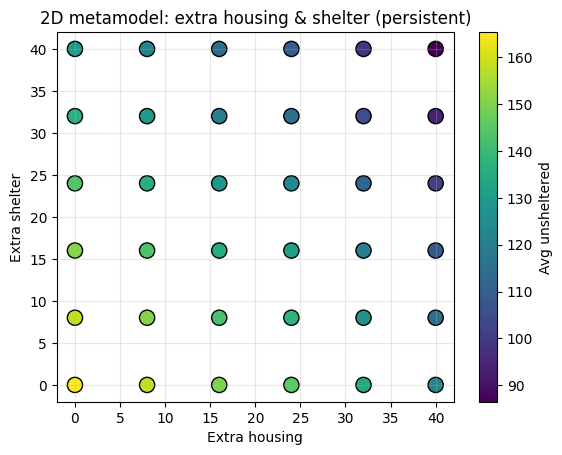

In [ ]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

H_vals = np.linspace(0, 40, 6).astype(int)
S_vals = np.linspace(0, 40, 6).astype(int)
PERSIST = True  

base_h = list(data['solution']['housing'])
base_s = list(data['solution']['shelter'])

pairs, ys = [], []

for H in H_vals:
    for S in S_vals:
        d = deepcopy(data)
        if PERSIST:
            d['solution']['housing'] = [h + H for h in base_h]
            d['solution']['shelter'] = [s + S for s in base_s]
        else:
            d['solution']['housing'] = [base_h[0] + H] + base_h[1:]
            d['solution']['shelter'] = [base_s[0] + S] + base_s[1:]

        sim = sm.SimulationModel(d, d['solution'])
        sim.analyse()
        y = float(np.mean(sim.results['unsheltered_q_avg']))

        pairs.append((H, S))
        ys.append(y)

pairs = np.asarray(pairs, float)
ys = np.asarray(ys, float)
H = pairs[:, 0]
S = pairs[:, 1]

fig, ax = plt.subplots(facecolor='white')

sc = ax.scatter(H, S, c=ys, cmap='viridis', s=120, edgecolor='k')

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Avg unsheltered')

ax.set_title('2D metamodel: extra housing & shelter (persistent)')
ax.set_xlabel('Extra housing')
ax.set_ylabel('Extra shelter')
ax.grid(True, alpha=0.3)

plt.show()


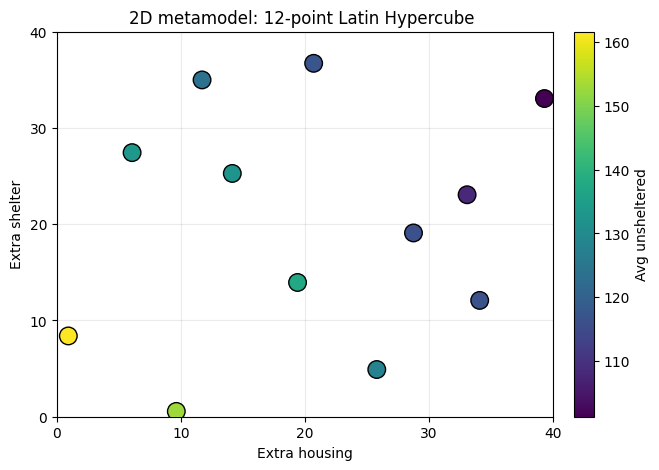

In [ ]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

# ---------- Latin Hypercube in 2D ----------
def lhs_2d(n, x_min, x_max, y_min, y_max, seed=123):
    rng = np.random.default_rng(seed)
    i = np.arange(n)
    j = rng.permutation(n)       # one-per-column
    u = rng.random(n)            # random offset within chunk
    v = rng.random(n)
    x = x_min + (i + u) * (x_max - x_min) / n
    y = y_min + (j + v) * (y_max - y_min) / n
    return x, y

# Settings
N = 12
H_min, H_max = 0.0, 40.0
S_min, S_max = 0.0, 40.0
SEED = 123

# 12 LHS points 
H_plot, S_plot = lhs_2d(N, H_min, H_max, S_min, S_max, seed=SEED)

H_sim = np.clip(np.rint(H_plot).astype(int), H_min, H_max)
S_sim = np.clip(np.rint(S_plot).astype(int), S_min, S_max)

# ---------- Run DES at those points ----------
PERSIST = True
base_h = list(data['solution']['housing'])
base_s = list(data['solution']['shelter'])

ys = []
for H_i, S_i in zip(H_sim, S_sim):
    d = deepcopy(data)
    if PERSIST:
        d['solution']['housing'] = [h + int(H_i) for h in base_h]
        d['solution']['shelter'] = [s + int(S_i) for s in base_s]
    else:
        d['solution']['housing'] = [base_h[0] + int(H_i)] + base_h[1:]
        d['solution']['shelter'] = [base_s[0] + int(S_i)] + base_s[1:]
    sim = sm.SimulationModel(d, d['solution'])
    sim.analyse()
    ys.append(float(np.mean(sim.results['unsheltered_q_avg'])))

ys = np.asarray(ys, float)

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

fig, ax = plt.subplots(figsize=(7, 5), facecolor='white')
ax.set_facecolor('white')

sc = ax.scatter(H_plot, S_plot, c=ys, cmap='viridis',
                s=160, edgecolor='k', linewidth=1.0, zorder=3)

cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Avg unsheltered')
cbar.ax.set_facecolor('white')

ax.set_xlim(H_min, H_max)
ax.set_ylim(S_min, S_max)
ax.set_xticks([0,10,20,30,40])
ax.set_yticks([0,10,20,30,40])

ax.set_title('2D metamodel: 12-point Latin Hypercube ')
ax.set_xlabel('Extra housing')
ax.set_ylabel('Extra shelter')
ax.grid(True, alpha=0.25, zorder=0)

plt.show()


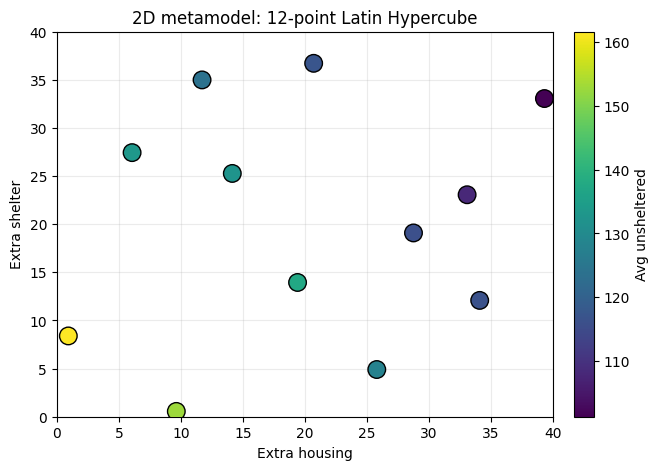

In [ ]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

# ---------- Latin Hypercube in 2D  ----------
def lhs_2d(n, x_min, x_max, y_min, y_max, seed=123):
    rng = np.random.default_rng(seed)
    i = np.arange(n)
    j = rng.permutation(n)       # one-per-column
    u = rng.random(n)            # random offset within chunk
    v = rng.random(n)
    x = x_min + (i + u) * (x_max - x_min) / n
    y = y_min + (j + v) * (y_max - y_min) / n
    return x, y

# Settings
N = 12
H_min, H_max = 0.0, 40.0
S_min, S_max = 0.0, 40.0
SEED = 123

# 12 LHS points (continuous for plotting)
H_plot, S_plot = lhs_2d(N, H_min, H_max, S_min, S_max, seed=SEED)

H_sim = np.clip(np.rint(H_plot).astype(int), H_min, H_max)
S_sim = np.clip(np.rint(S_plot).astype(int), S_min, S_max)

# ---------- Run DES at those points ----------
PERSIST = True
base_h = list(data['solution']['housing'])
base_s = list(data['solution']['shelter'])

ys = []
for H_i, S_i in zip(H_sim, S_sim):
    d = deepcopy(data)
    if PERSIST:
        d['solution']['housing'] = [h + int(H_i) for h in base_h]
        d['solution']['shelter'] = [s + int(S_i) for s in base_s]
    else:
        d['solution']['housing'] = [base_h[0] + int(H_i)] + base_h[1:]
        d['solution']['shelter'] = [base_s[0] + int(S_i)] + base_s[1:]
    sim = sm.SimulationModel(d, d['solution'])
    sim.analyse()
    ys.append(float(np.mean(sim.results['unsheltered_q_avg'])))

ys = np.asarray(ys, float)

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

fig, ax = plt.subplots(figsize=(7, 5), facecolor='white')
ax.set_facecolor('white')

sc = ax.scatter(H_plot, S_plot, c=ys, cmap='viridis',
                s=160, edgecolor='k', linewidth=1.0, zorder=3)

cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Avg unsheltered')
cbar.ax.set_facecolor('white')

ax.set_xlim(H_min, H_max)
ax.set_ylim(S_min, S_max)
# --- 5-unit ticks ---
ax.set_xticks(np.arange(H_min, H_max + 0.1, 5))
ax.set_yticks(np.arange(S_min, S_max + 0.1, 5))

ax.set_title('2D metamodel: 12-point Latin Hypercube')
ax.set_xlabel('Extra housing')
ax.set_ylabel('Extra shelter')
ax.grid(True, alpha=0.25, zorder=0)

plt.show()


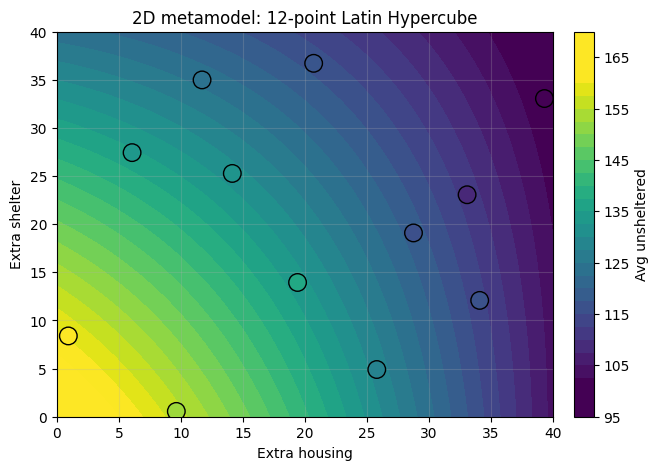

In [ ]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

# ---------- Latin Hypercube in 2D  ----------
def lhs_2d(n, x_min, x_max, y_min, y_max, seed=123):
    rng = np.random.default_rng(seed)
    i = np.arange(n)
    j = rng.permutation(n)       # one-per-column
    u = rng.random(n)            # random offset within chunk
    v = rng.random(n)
    x = x_min + (i + u) * (x_max - x_min) / n
    y = y_min + (j + v) * (y_max - y_min) / n
    return x, y

# Settings
N = 12
H_min, H_max = 0.0, 40.0
S_min, S_max = 0.0, 40.0
SEED = 123

# 12 LHS points 
H_plot, S_plot = lhs_2d(N, H_min, H_max, S_min, S_max, seed=SEED)

H_sim = np.clip(np.rint(H_plot).astype(int), H_min, H_max)
S_sim = np.clip(np.rint(S_plot).astype(int), S_min, S_max)

# ---------- Run DES at those points ----------
PERSIST = True
base_h = list(data['solution']['housing'])
base_s = list(data['solution']['shelter'])

ys = []
for H_i, S_i in zip(H_sim, S_sim):
    d = deepcopy(data)
    if PERSIST:
        d['solution']['housing'] = [h + int(H_i) for h in base_h]
        d['solution']['shelter'] = [s + int(S_i) for s in base_s]
    else:
        d['solution']['housing'] = [base_h[0] + int(H_i)] + base_h[1:]
        d['solution']['shelter'] = [base_s[0] + int(S_i)] + base_s[1:]
    sim = sm.SimulationModel(d, d['solution'])
    sim.analyse()
    ys.append(float(np.mean(sim.results['unsheltered_q_avg'])))
ys = np.asarray(ys, float)

X = np.column_stack([np.ones_like(H_sim), H_sim, S_sim, H_sim**2, S_sim**2, H_sim*S_sim])
beta, *_ = np.linalg.lstsq(X, ys, rcond=None)
b0, b1, b2, b3, b4, b5 = beta

H_grid = np.linspace(H_min, H_max, 300)
S_grid = np.linspace(S_min, S_max, 300)
HH, SS = np.meshgrid(H_grid, S_grid, indexing='ij')
YY = b0 + b1*HH + b2*SS + b3*HH**2 + b4*SS**2 + b5*(HH*SS)

# Colour scale driven by the dots (so background matches dot colours)
vmin, vmax = ys.min(), ys.max()

# ---------- Plot: coloured background + coloured circles; 5-unit ticks ----------
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

fig, ax = plt.subplots(figsize=(7, 5), facecolor='white')
ax.set_facecolor('white')

cs = ax.contourf(HH, SS, YY, levels=30, cmap='viridis', vmin=vmin, vmax=vmax)

sc = ax.scatter(H_plot, S_plot, c=ys, cmap='viridis',
                vmin=vmin, vmax=vmax, s=160, edgecolor='k', linewidth=1.0, zorder=3)

cbar = plt.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Avg unsheltered')
cbar.ax.set_facecolor('white')

ax.set_xlim(H_min, H_max)
ax.set_ylim(S_min, S_max)
ax.set_xticks(np.arange(H_min, H_max + 0.1, 5))
ax.set_yticks(np.arange(S_min, S_max + 0.1, 5))

ax.set_title('2D metamodel: 12-point Latin Hypercube')
ax.set_xlabel('Extra housing')
ax.set_ylabel('Extra shelter')
ax.grid(True, alpha=0.25, zorder=0)

plt.show()
